# Using Neural Networks For Future Price Bitcoin

In [8]:
import pandas as pd
df = pd.read_csv("BTC-Daily.csv")

#Check if NA values are in data
df=df[df['Volume BTC']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df.tail()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
2638,1417478400,2014-12-02 00:00:00,BTC/USD,378.39,382.86,375.23,379.25,2593576.46,6832.53
2639,1417392000,2014-12-01 00:00:00,BTC/USD,376.40,382.31,373.03,378.39,2520662.37,6660.56
2640,1417305600,2014-11-30 00:00:00,BTC/USD,376.57,381.99,373.32,373.34,1145566.61,3046.33
2641,1417219200,2014-11-29 00:00:00,BTC/USD,376.42,386.60,372.25,376.72,2746157.05,7245.19
2642,1417132800,2014-11-28 00:00:00,BTC/USD,363.59,381.34,360.57,376.28,3220878.18,8617.15


# Support and Resistance FUNCTIONS

In [9]:
def support(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.low[i]>df1.low[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.low[i]<df1.low[i-1]):
            return 0
    return 1

def resistance(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.high[i]<df1.high[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.high[i]>df1.high[i-1]):
            return 0
    return 1

In [10]:
length = len(df)
high = list(df['high'])
low = list(df['low'])
close = list(df['close'])
open = list(df['open'])
bodydiff = [0] * length

highdiff = [0] * length
lowdiff = [0] * length
ratio1 = [0] * length
ratio2 = [0] * length

def isEngulfing(l):
    row=l
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001      

    bodydiffmin = 0.002
    if (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]<close[row-1] and
        open[row]>close[row] and 
        (open[row]-close[row-1])>=-0e-5 and close[row]<open[row-1]): #+0e-5 -5e-5
        return 1

    elif(bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]>close[row-1] and
        open[row]<close[row] and 
        (open[row]-close[row-1])<=+0e-5 and close[row]>open[row-1]):#-0e-5 +5e-5
        return 2
    else:
        return 0
       
def isStar(l):
    bodydiffmin = 0.0020
    row=l
    highdiff[row] = high[row]-max(open[row],close[row])
    lowdiff[row] = min(open[row],close[row])-low[row]
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001
    ratio1[row] = highdiff[row]/bodydiff[row]
    ratio2[row] = lowdiff[row]/bodydiff[row]

    if (ratio1[row]>1 and lowdiff[row]<0.2*highdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]>close[row]):
        return 1
    elif (ratio2[row]>1 and highdiff[row]<0.2*lowdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]<close[row]):
        return 2
    else:
        return 0
    
def closeResistance(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.high[l]-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c2 = abs(max(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c3 = min(df.open[l],df.close[l])<min(levels, key=lambda x:abs(x-df.high[l]))
    c4 = df.low[l]<min(levels, key=lambda x:abs(x-df.high[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0
    
def closeSupport(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.low[l]-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c2 = abs(min(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c3 = max(df.open[l],df.close[l])>min(levels, key=lambda x:abs(x-df.low[l]))
    c4 = df.high[l]>min(levels, key=lambda x:abs(x-df.low[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0

In [11]:
n1=2
n2=2
backCandles=30
signal = [0] * length

for row in range(backCandles, len(df)-n2):
    ss = []
    rr = []
    for subrow in range(row-backCandles+n1, row+1):
        if support(df, subrow, n1, n2):
            ss.append(df.low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.high[subrow])
    #!!!! parameters
    if ((isEngulfing(row)==1 or isStar(row)==1) and closeResistance(row, rr, 150e-5) ):#and df.RSI[row]<30
        signal[row] = 1
    elif((isEngulfing(row)==2 or isStar(row)==2) and closeSupport(row, ss, 150e-5)):#and df.RSI[row]>70
        signal[row] = 2
    else:
        signal[row] = 0



In [12]:
df['signal']=signal

In [13]:
df[df['signal']==1].count()

unix          20
date          20
symbol        20
open          20
high          20
low           20
close         20
Volume BTC    20
Volume USD    20
signal        20
dtype: int64

In [14]:
df.columns = 'Unix', 'Local time', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume BTC', 'Volume USD', 'signal', 'signal']
#df=df.iloc[100:200]
df

,Unix,Local time,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,signal
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,4.900629e+01,2.116360e+06,0
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3.160618e+03,1.364723e+08,0
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1.701817e+03,6.418008e+07,0
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,9.127241e+02,3.573010e+07,0
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2.202852e+03,8.642149e+07,0
...,...,...,...,...,...,...,...,...,...,...
2638,1417478400,2014-12-02 00:00:00,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03,0
2639,1417392000,2014-12-01 00:00:00,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03,0
2640,1417305600,2014-11-30 00:00:00,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03,0
2641,1417219200,2014-11-29 00:00:00,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03,0


In [15]:
def SIGNAL():
    return df.signal

In [16]:
#A new strategy needs to extend Strategy class and override its two abstract methods: init() and next().
#Method init() is invoked before the strategy is run. Within it, one ideally precomputes in efficient, 
#vectorized manner whatever indicators and signals the strategy depends on.
#Method next() is then iteratively called by the Backtest instance, once for each data point (data frame row), 
#simulating the incremental availability of each new full candlestick bar.

#Note, backtesting.py cannot make decisions / trades within candlesticks — any new orders are executed on the
#next candle's open (or the current candle's close if trade_on_close=True). 
#If you find yourself wishing to trade within candlesticks (e.g. daytrading), you instead need to begin 
#with more fine-grained (e.g. hourly) data.

In [17]:
from backtesting import Strategy

class MyCandlesStrat(Strategy):  
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next() 
        if self.signal1==2:
            sl1 = self.data.Close[-1] - 600e-4
            tp1 = self.data.Close[-1] + 450e-4
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1==1:
            sl1 = self.data.Close[-1] + 600e-4
            tp1 = self.data.Close[-1] - 450e-4
            self.sell(sl=sl1, tp=tp1)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [18]:
from backtesting import Backtest

bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)
stat = bt.run()
stat



C:\Users\ASUS\AppData\Local\Temp\ipykernel_20080\1132592598.py:3: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20080\1132592598.py:3: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)


Start                                     0.0
End                                    2642.0
Duration                               2642.0
Exposure Time [%]                    1.286417
Equity Final [$]                      5594.18
Equity Peak [$]                       10000.0
Return [%]                           -44.0582
Buy & Hold Return [%]              -99.128689
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                    -44.0582
Avg. Drawdown [%]                    -44.0582
Max. Drawdown Duration                 1997.0
Avg. Drawdown Duration                 1997.0
# Trades                                 34.0
Win Rate [%]                              0.0
Best Trade [%]                           -0.0
Worst Trade [%]                    -10.724665
Avg. Trade [%]                    

In [19]:
bt.plot()

GridPlot(id='p1291', ...)

In [20]:
#Target flexible way
pipdiff = 250*1e-4 #for TP
SLTPRatio = 1 #pipdiff/Ratio gives SL
def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
        #if ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 2 # bth limits exceeded
        #elif ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 3 #-1 downtrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
        #    trendcat[line] = 1 # uptrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 0 # no trend
        #elif ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 5 # light trend down
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 4 # light trend up
            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

<Axes: >

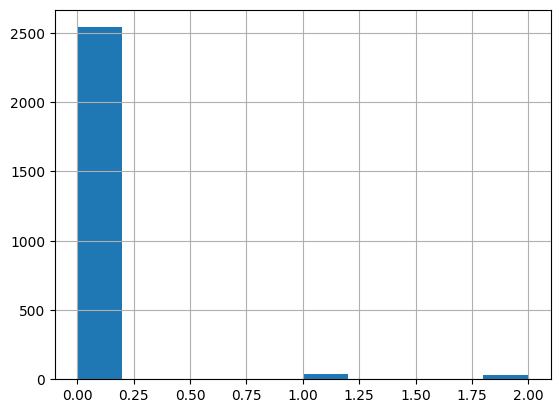

In [21]:
#!!! pitfall one category high frequency
df['Target'] = mytarget(30, df)
#df.tail(20)
#df['Target'] = df['Target'].astype(int)
df['Target'].hist()

In [22]:
import pandas_ta as pa
df["RSI"] = pa.rsi(df.Close, length=16)
df.tail(20)

,Unix,Local time,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,signal,Target,RSI
2623,1418860800,2014-12-18 00:00:00,BTC/USD,321.32,325.61,304.99,312.17,6788858.09,21637.58,0,NaN,56.736708
2624,1418774400,2014-12-17 00:00:00,BTC/USD,331.56,335.99,315.23,321.10,7586686.22,23478.02,0,NaN,59.069521
2625,1418688000,2014-12-16 00:00:00,BTC/USD,350.17,350.17,330.00,330.02,1902071.15,5677.83,0,NaN,61.293286
2626,1418515200,2014-12-14 00:00:00,BTC/USD,351.45,351.98,348.96,350.17,196831.56,561.33,0,NaN,65.773907
2627,1418428800,2014-12-13 00:00:00,BTC/USD,354.48,354.95,347.03,351.45,1359211.39,3880.75,0,NaN,66.040274
2628,1418342400,2014-12-12 00:00:00,BTC/USD,348.98,358.59,348.00,354.48,2846451.59,8039.95,0,NaN,66.694754
2629,1418256000,2014-12-11 00:00:00,BTC/USD,348.13,364.43,339.80,348.98,5842055.01,16533.38,0,NaN,64.295577
2630,1418169600,2014-12-10 00:00:00,BTC/USD,350.49,353.74,347.23,348.13,2304335.87,6579.79,0,NaN,63.916552
2631,1418083200,2014-12-09 00:00:00,BTC/USD,364.61,365.48,343.97,350.49,7376463.45,20940.84,0,NaN,64.535709
2632,1417996800,2014-12-08 00:00:00,BTC/USD,376.87,377.45,364.60,364.61,3655238.40,9920.84,0,NaN,68.036008


In [23]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
print(df.describe())

               Unix          Open          High           Low         Close  \
count  2.595000e+03   2595.000000   2595.000000   2595.000000   2595.000000   
mean   1.532641e+09  11692.802224  12037.675561  11295.043592  11708.888004   
std    6.474905e+07  16232.488971  16696.827405  15677.531369  16242.284717   
min    1.419984e+09    162.000000    212.840000    152.400000    162.000000   
25%    1.476619e+09    676.770000    686.560000    661.850000    678.475000   
50%    1.532650e+09   6451.030000   6589.790000   6340.010000   6456.770000   
75%    1.588680e+09  10676.405000  10949.945000  10292.070000  10689.645000   
max    1.644710e+09  67547.490000  69000.000000  66250.000000  67559.000000   

         Volume BTC    Volume USD       signal       Target          RSI  
count  2.595000e+03  2.595000e+03  2595.000000  2595.000000  2595.000000  
mean   1.355090e+07  6.180620e+07     0.027746     0.038921    45.812990  
std    4.762784e+07  1.080739e+08     0.216870     0.249184    

In [24]:
attributes = ['RSI', 'signal', 'Target']
df_model= df[attributes].copy()

df_model['signal'] = pd.Categorical(df_model['signal'])
dfDummies = pd.get_dummies(df_model['signal'], prefix = 'signalcategory')
df_model= df_model.drop(['signal'], axis=1)
df_model = pd.concat([df_model, dfDummies], axis=1)
df_model

,RSI,Target,signalcategory_0,signalcategory_1,signalcategory_2
0,52.317135,0.0,True,False,False
1,52.929605,0.0,True,False,False
2,53.572366,0.0,True,False,False
3,57.742421,0.0,True,False,False
4,60.774131,0.0,True,False,False
...,...,...,...,...,...
2590,57.125279,0.0,True,False,False
2591,60.867840,0.0,True,False,False
2592,65.454316,0.0,True,False,False
2593,65.400701,0.0,True,False,False


In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss

attributes = ['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 97.7423%
****Test Results****
Accuracy: 96.4056%


In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)
#choices = [2, 0, -1, +1]
##choices = [2, 0, 3, +1]
print(model.get_booster().feature_names)

[[1775    0    0]
 [  19    0    0]
 [  22    0    0]]
[[751   0   0]
 [ 18   0   0]
 [ 10   0   0]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1775
         1.0       0.00      0.00      0.00        19
         2.0       0.00      0.00      0.00        22

    accuracy                           0.98      1816
   macro avg       0.33      0.33      0.33      1816
weighted avg       0.96      0.98      0.97      1816

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       751
         1.0       0.00      0.00      0.00        18
         2.0       0.00      0.00      0.00        10

    accuracy                           0.96       779
   macro avg       0.32      0.33      0.33       779
weighted avg       0.93      0.96      0.95       779

['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.

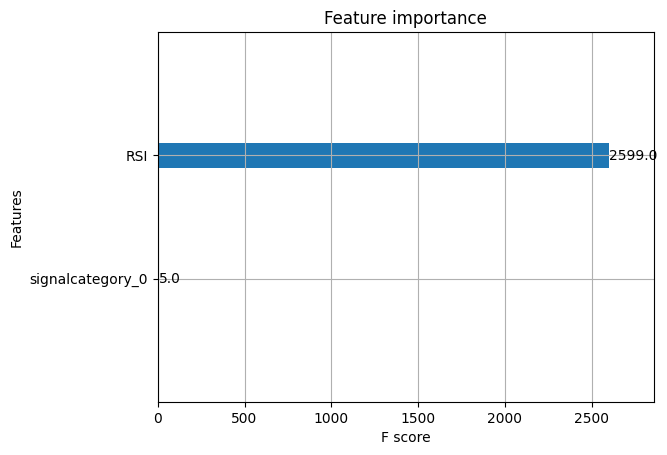

['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']


In [27]:
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
#pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
#plot feature importance
plot_importance(model)
pyplot.show()
print(model.get_booster().feature_names)

In [28]:
from sklearn.neural_network import MLPClassifier

attributes = ['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.6 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

NN = MLPClassifier(hidden_layer_sizes=(50, 50, 60, 30, 9), random_state=100, verbose=0, max_iter=1000, activation='relu')
NN.fit(X_train, y_train)
pred_train = NN.predict(X_train)
pred_test = NN.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print("="*20)

print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test)) 

****Train Results****
Accuracy: 97.8163%
****Test Results****
Accuracy: 96.6281%


In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)

[[1523    0    0]
 [  16    0    0]
 [  18    0    0]]
[[1003    0    0]
 [  21    0    0]
 [  14    0    0]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1523
         1.0       0.00      0.00      0.00        16
         2.0       0.00      0.00      0.00        18

    accuracy                           0.98      1557
   macro avg       0.33      0.33      0.33      1557
weighted avg       0.96      0.98      0.97      1557

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1003
         1.0       0.00      0.00      0.00        21
         2.0       0.00      0.00      0.00        14

    accuracy                           0.97      1038
   macro avg       0.32      0.33      0.33      1038
weighted avg       0.93      0.97      0.95      1038



C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.